# Who can replace João Félix?

### by João Gouveia
<br></br>

<img src="files/joaofelix2.jpg">

<br></br>
<a class="anchor" id="Table_Contents"></a>
### TABLE OF CONTENTS

* [# 1. Introduction](#intro)

* [# 2. Data Understanding](#data-understanding)
    
* [# 3. Data Preparation](#data-preparation)

* [# 3. Modelling](#modelling)

* [# 4. Results](#results)

* [# 5. Made in Benfica?](#madein)

<a class="anchor" id="intro"></a>
# Introduction

Even though we are still on the middle of the Summer, this football's transfer window will be forever be on the Portuguese football fans' mind. After a great season from João Félix in SL Benfica, the historical Spanish club Atlético de Madrid shocked the World of Football by purchasing the Portuguese wonderkid by an impressive fee of 126 million euros. Due to the great contribution that Félix had on Benfica's success during the past season, this transfer turned out as a huge headache for the club's structure and head coach, Bruno Lage.

Hence, this project! In a way to combine two things that I love - sports and data analysis -, I decided to use Machine Learning and other techniques to find out who could replace João Félix in Benfica, by finding a set of players that share some resemblance with the Portuguese player. I tried to write this notebook in a way that even people that is not highly familiar with the so-called Data Science could easily understood all the steps I took to reach the conclusions.

<a class="anchor" id="data-understanding"></a>
# Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

After importing the most common python libraries, it was important to define which database I should use in order to answer to the question. At first, I wanted to use the Football Manager database, not only because it was an important part of my childhood (as a regular wanna-be coach) but also because it is more vast and complete. However, the only FM database I could find was from 2017, leading me to use the FIFA 19 database instead (available on Kaggle).

In [2]:
fifadb = pd.read_csv('fifadb.csv')

Once the dataset was imported, it was time to start digging and understand how it is built. And so, the next steps are essentially to perform general analysis on all the data, before proceding to the data preparation phase.

In [5]:
fifadb.shape

(18207, 89)

In [6]:
fifadb.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

With these two pieces of code, it is possible to see that this dataset comprises the information (89 variables) of 18.207 players.

In [3]:
fifadb.isna().sum()/len(fifadb)*100

Unnamed: 0                   0.000000
ID                           0.000000
Name                         0.000000
Age                          0.000000
Photo                        0.000000
Nationality                  0.000000
Flag                         0.000000
Overall                      0.000000
Potential                    0.000000
Club                         1.323667
Club Logo                    0.000000
Value                        0.000000
Wage                         0.000000
Special                      0.000000
Preferred Foot               0.263635
International Reputation     0.263635
Weak Foot                    0.263635
Skill Moves                  0.263635
Work Rate                    0.263635
Body Type                    0.263635
Real Face                    0.263635
Position                     0.329544
Jersey Number                0.329544
Joined                       8.529686
Loaned From                 93.057615
Contract Valid Until         1.587302
Height      

Above, one may see that there are several missing values in some variables (not all though). This will be a burden for the clustering part.

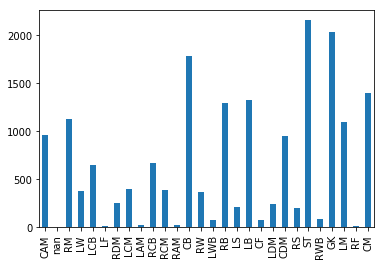

In [4]:
position_totals = {}
 
for i in set(fifadb['Position']):
    count = 0
    for j in fifadb['Position']:
        if j == i:
            count+=1
    position_totals[i] = count

position_totals = pd.Series(position_totals)
position_totals.plot('bar')

The majority of the players are either strikers, central backs or goalkeepers.

<a class="anchor" id="data-preparation"></a>
# Data Preparation

Moving on to the data preparation for the cluster analysis, some changes on the dataset must be made. For instance, there are sevelal missing values on the attributes variables, however, the % of missing values in them is always the same, leading me to assume the players are the same.

In [5]:
fifadb = fifadb.loc[fifadb['Crossing'].isna() == False]

Also, since my computer is not a <i> great machine </i>, every change that I do to minimize the lenght of the dataset will be useful for the computations ahead. As such, I'm going to drop the rows belonging to Goalkeepers and also the attributes related to them.

In [7]:
fifadb = fifadb.loc[fifadb['Position']!='GK']

In [9]:
gk_att = ['GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']

fifadb.drop(gk_att, axis=1, inplace=True)

One important aspect to bear in mind for the cluster analysis is the standardization of the variables. However, since the attributes of the players are already standardized (comprised in 0-99), no transformation will be needed.

<a class="anchor" id="modelling"></a>
# Modelling

In order to find who are the most similar comparable players to João Félix, the narrowing process will be composed by two phases: a first one where a K-Means analysis is performed, and a second one in which the distances between the vector with the Félix's attributes and the others players' one are computed and sorted.

To begin with, it is necessary to import the `KMeans` module from SKLearn.

In [12]:
from sklearn.cluster import KMeans

Afterwards, a subset `fifabdb_val` containing all the players' attributes will be created in order to be used in the modelling part.

In [13]:
fifadb_val = fifadb[['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']]

One of the main disadvantages of K-Means is the need to define the number of existent clusters. To help, one good measure is to plot the different levels of inertia depending on the number of clusters. At this time, those who are not experts (yet, like me!) may be wondering <i> "What the hell is inertia?" </i>.

Well, it's not easy to explain by words but imagine that you have only one cluster. It's easy to conclude that all the points will belong to the only cluster and, in that case, inertia is the the sum of the squares of the distances from those points to the centroid (middle of the cluster). If we increase the number of clusters, the distance of the points to the respective cluster will decrease. Although it might seem subjective (and it is, a little), a good starting point for the number of clusters is the so-called "elbow" of the plot, where the inertias start to stabilize.

In [24]:
ks = range(1, 8)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k, n_init = 50, precompute_distances = True, max_iter = 500)
    model.fit(fifadb_val)
    inertias.append(model.inertia_)

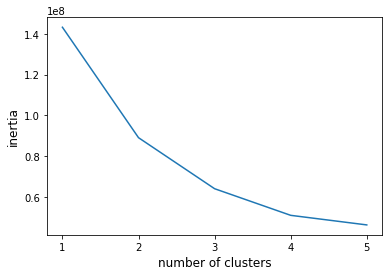

In [25]:
plt.plot(ks, inertias)
plt.xlabel('number of clusters', fontsize = 12)
plt.ylabel('inertia', fontsize = 12)
plt.xticks(np.arange(min(ks), max(ks) + 1, 1))
plt.show()

As seens above, two possible numbers are 3 and 4. Since I want to decrease the number of players in order to compute the distances after, I think 3 clusters are enough. In the next pieces of code, I'm going to create the model and fit it to the data (`fifadb_val`)

In [14]:
model = KMeans(n_clusters=3)

In [15]:
model.fit(fifadb_val)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once the data is fitted to the model, one might extract the outcome labels (stating the cluster that each player belongs to). After that, I will append a collumn named `Label` to the initial dataset `fifadb`.

In [16]:
labels = model.predict(fifadb_val)

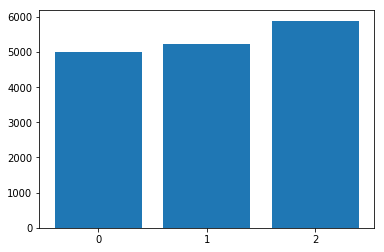

In [17]:
labels_set = set(labels)

totals = {}

for i in set(labels):
    sum = 0
    for j in labels:
        if i==j:
            sum += 1
        else:
            sum += 0
    totals[i] = sum

plt.bar(range(len(totals)), totals.values(), align='center')
plt.xticks(range(len(totals)), list(totals.keys()))
plt.show()

In [19]:
fifadb['Label'] = model.labels_

The clusters have relatively the same size (containing around 5000 and 6000 players). The following code computes the attributes' mean for each label/cluster. 

In [26]:
descr = fifadb[['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle','Label']].groupby(['Label']).mean().T
descr

Label,0,1,2
Finishing,31.046953,53.107102,62.682227
HeadingAccuracy,59.256344,58.111684,54.255305
ShortPassing,56.676324,69.760787,61.347819
Volleys,31.479121,51.289423,55.656765
Dribbling,48.003596,66.487591,66.016466
Curve,36.720080,60.472700,55.381429
FKAccuracy,34.047752,55.474227,48.901545
LongPassing,50.714885,65.991027,51.849431
BallControl,54.114885,69.036082,65.706501
Acceleration,61.153846,68.819206,72.853336


By the previous analysis, there are some interesting insights that one can already draw. For instance, cluster 1 and 2 have higher average of Finishing, ShotPower, Dribbling and SprintSpeed. While cluster 0 and 1 have the higher average of Marking, StandingTackle and SlidingTackle.

This leads me to conclude that the majority of the strikers are in the cluster 2 and the defenders in cluster 0. Regarding the cluster 1, it is very mixed in terms of attributes, which might indicate a high percentage of midfielders.

In order to narrow the dataset, it is important to know what is the cluster in which João Félix is.

In [27]:
JF_label = fifadb.loc[fifadb['Name']=='João Félix']['Label']
JF_label

2

João Félix belongs to the cluster 2, which makes sense regarding our previous analysis. The Portuguese wonderkid is an attacking midfielder, playing an important role in the last third of the field.

In this next step, I will narrow the dataset to players belonging to the same cluster as João Félix (and calling it `fifadb_2`).

In [33]:
fifadb_2 = fifadb.loc[fifadb['Label']==int(JF_label)]

The vector containing the attributes of Félix is stored in `JF_vector`.

In [34]:
JF_vector = fifadb_2.loc[fifadb_2['Name']=='João Félix'][['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].values

JF_vector

array([[64., 58., 70., 67., 78., 72., 51., 67., 77., 77., 80., 84., 70.,
        78., 72., 78., 73., 60., 68., 51., 38., 62., 72., 53., 73., 28.,
        42., 35.]])

To narrow even more the dataset, from now on, I will only work with athletes that are 21 years old or younger (it will be stored in a dataset called `fifadb_3`).

In [35]:
fifadb_3 = fifadb_2.loc[(fifadb_2['Age']<=21) & (fifadb_2['Name']!='João Félix')]

Now it's time for the second step. Within the cluster of JF, I will compute the distances from those points to `JF_vector`. After that, I will compute the inverse of each distance value, to build a similarity measure (higher the value, closer to the vector).

In [36]:
from scipy.spatial import distance

similarities = {}

for i in fifadb_3['ID'].values:
    v = fifadb_3.loc[fifadb_3['ID']==i][['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].values
    sim = 1/(distance.euclidean(JF_vector,v))
    similarities[i] = sim = 1/(distance.euclidean(JF_vector,v))


In the next step I will standardize it, applying a Min-Max transformation and append it to `fifadb_3`, naming it `Similar`.

In [37]:
max_s = max(similarities.values())
min_s = min(similarities.values())

for i in similarities:
    similarities[i] = round(((similarities[i]-min_s)/(max_s-min_s)*100),2)

In [38]:
similarities = pd.DataFrame(similarities.items(), columns=['ID', 'Similar'])

In [39]:
fifadb_3 = pd.merge(fifadb_3, similarities, how='inner', on='ID', left_on=None, right_on=None)

<a class="anchor" id="results"></a>
# Results

Finally, it is time to check the results. The next piece of code, orders the similarity by descending order and filtering the players according to its Potential (higher or equal to 83).

In [41]:
fifadb_3.sort_values(by='Similar', ascending=False).drop(['Photo','Club Logo','Flag'],
                                                    axis=1).loc[fifadb_3['Potential']>=83][['ID',
                                                    'Name', 'Age', 'Nationality',
                                                    'Overall', 'Potential', 'Club', 'Value',
                                                    'Wage', 'Similar']].head(12).T

,237,127,67,44,49,86,8,34,74,76,35,58
ID,241026,239970,241168,231826,244193,236786,235790,233631,237670,239482,234711,233550
Name,T. Chancalay,Paulinho,G. Chakvetadze,Y. Karamoh,Jovane Cabral,M. Terrier,K. Havertz,A. Ndiaye Diedhiou,Bruno Xadas,Galeno,J. Brekalo,S. Grandsir
Age,19,17,18,19,20,21,19,21,20,20,20,21
Nationality,Argentina,Brazil,Georgia,France,Cape Verde,France,Germany,Senegal,Portugal,Brazil,Croatia,France
Overall,68,71,73,75,75,73,80,76,73,73,76,74
Potential,83,86,86,85,87,83,89,85,84,84,84,85
Club,Club Atlético Colón,Bayer 04 Leverkusen,KAA Gent,FC Girondins de Bordeaux,Sporting CP,Olympique Lyonnais,Bayer 04 Leverkusen,Getafe CF,SC Braga,Rio Ave FC,VfL Wolfsburg,AS Monaco
Value,€1.9M,€4.7M,€7M,€10.5M,€12M,€6.5M,€22M,€12M,€7M,€7M,€11.5M,€9.5M
Wage,€3K,€15K,€10K,€24K,€9K,€35K,€32K,€17K,€9K,€9K,€33K,€36K
Similar,100,98.44,83.91,81.66,81.41,78.56,78.33,73.36,72.86,67.4,65.57,63.22


It is interesting to see that there are some familiar names and some unknown in this final TOP12. On one side we have Havertz which is one of the most promising players in the World. We also can see Jovane Cabral from Sporting CP and also Bruno Xadas and Galeno. On the other side, in terms of attributes, the player that shows the highest resemblance with João Félix is Tomás Chancalay: a 19 years old Argentinian kid that plays for Colón. Is he closer to a big move to Europe or will he be one of the many players across the World that will never match its potential. Time will tell... 

<a class="anchor" id="madein"></a>
# <i> Made in </i> Benfica?

Nevertheless, and being Benfica a top-tier academy, it seems logical to think that the answer to João Félix's transfer might already being training in Seixal. As such, the following analysis will look into the similarity between Félix and the former colleagues. Unfortunately, neither João Filipe (aka Jota) nor Adel Taarabt are in this dataset.

In [66]:
SLB_players = fifadb.loc[fifadb['Club']=='SL Benfica']

In [85]:
SLB_newplayers = fifadb.loc[(fifadb['ID']==210315) | (fifadb['ID']==243686) | (fifadb['ID']==244621)]
SLB_newplayers

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,Release Clause,Label
1409,1409,210315,De Tomás,23,https://cdn.sofifa.org/players/4/19/210315.png,Spain,https://cdn.sofifa.org/flags/45.png,76,83,Rayo Vallecano,...,22.0,75.0,48.0,75.0,62.0,53.0,16.0,20.0,NaN,2
3887,3887,243686,Chiquinho,22,https://cdn.sofifa.org/players/4/19/243686.png,Portugal,https://cdn.sofifa.org/flags/38.png,72,78,Moreirense FC,...,51.0,67.0,72.0,74.0,68.0,46.0,56.0,41.0,€9.8M,2
7190,7190,244621,Vinícius,23,https://cdn.sofifa.org/players/4/19/244621.png,Brazil,https://cdn.sofifa.org/flags/54.png,68,75,Rio Ave FC,...,16.0,68.0,57.0,68.0,71.0,20.0,22.0,21.0,NaN,2


In [68]:
SLB_players = SLB_players.append(SLB_newplayers)

In [69]:
SLB_players = SLB_players.loc[SLB_players['Name']!='João Félix']

In [80]:
SLB_similarities = {}

for i in SLB_players['ID'].values:
    v = SLB_players.loc[SLB_players['ID']==i][['Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle']].values
    sim = 1/(distance.euclidean(JF_vector,v))
    SLB_similarities[i] = sim

In [81]:
for i in SLB_similarities:
    SLB_similarities[i] = round(((SLB_similarities[i]-min_s)/(max_s-min_s)*100),2)

In [82]:
SLB_similarities = pd.DataFrame(SLB_similarities.items(), columns=['ID', 'Similar'])

In [83]:
SLB_players = pd.merge(SLB_players, SLB_similarities, how='inner', on='ID', left_on=None, right_on=None)

In [91]:
SLB_players.sort_values(by='Similar', ascending=False).head(12)[['ID',
                                                    'Name', 'Age', 'Nationality',
                                                    'Overall', 'Potential', 'Club', 'Value', 'Wage',
                                                    'Position', 'Similar']].T

,6,15,23,13,10,5,9,28,14,0,27,18
ID,216547,213432,193408,220746,230988,190972,223061,243686,212878,176769,210315,234568
Name,Rafa,F. Ferreyra,H. Seferović,A. Živković,F. Krovinović,E. Salvio,F. Cervi,Chiquinho,N. Castillo,Jonas,De Tomás,Gedson Fernandes
Age,25,27,26,21,22,27,24,22,25,34,23,19
Nationality,Portugal,Argentina,Switzerland,Serbia,Croatia,Argentina,Argentina,Portugal,Chile,Brazil,Spain,Portugal
Overall,80,77,74,77,78,81,79,72,77,84,76,76
Potential,83,78,76,84,84,81,84,78,82,84,83,86
Club,SL Benfica,SL Benfica,SL Benfica,SL Benfica,SL Benfica,SL Benfica,SL Benfica,Moreirense FC,SL Benfica,SL Benfica,Rayo Vallecano,SL Benfica
Value,€18.5M,€10.5M,€7M,€12.5M,€14M,€18.5M,€17M,€4.3M,€12M,€16.5M,€11M,€12M
Wage,€17K,€14K,€12K,€11K,€12K,€19K,€15K,€5K,€14K,€25K,€105K,€6K
Position,RW,ST,ST,LW,CAM,RW,LW,LCM,ST,ST,ST,RCM


According to this dataset and analysis, Rafa would be the best player to replace João Félix in the line-up. Which makes sense because it was a role in which he player several times when he was in Braga. Another interesting result is Zivkovic being the 4th, since he is one of the last options to the wing positions. Is it here the ultimate opportunity for the Serbian finally win an important role in the team? Time, but specially Bruno Lage, will tell...